<a href="https://colab.research.google.com/github/matthiasdialpad/pCSAT/blob/master/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import string
import torch
import itertools
import seaborn as sns
from tqdm import tqdm
from google.cloud import bigquery
from google.cloud import storage
from datetime import date
from google.colab import files, auth
import matplotlib.pyplot as plt
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Annotating labels for plots
def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/3, label_position, label, kwargs)
    return None

In [3]:
project_id = 'talkiq-data'
metrics_dest_table = 'ai_research.csat_utterance'
client = bigquery.Client(project=project_id)

In [4]:
query = """
SELECT *
FROM `talkiq-data.ai_research.csat_utterance`
"""

In [5]:
def read_from_database(query):
    query_job = client.query(query)  
    df = query_job.to_dataframe()
    print('Done')
    return df

In [6]:
df = read_from_database(query)

Done


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184993 entries, 0 to 1184992
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   call_id              1184993 non-null  object             
 1   call_leg_id          1184993 non-null  object             
 2   call_side            1184993 non-null  object             
 3   response_value       1184993 non-null  object             
 4   response_csat_value  23931 non-null    object             
 5   final_utterance      1184993 non-null  object             
 6   time_start           1184993 non-null  float64            
 7   time_end             1184993 non-null  float64            
 8   PARTITIONTIME        1184993 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(6)
memory usage: 81.4+ MB


In [ ]:
df[['response_value']] = df[['response_value']].astype(str).astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184993 entries, 0 to 1184992
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   call_id              1184993 non-null  object             
 1   call_leg_id          1184993 non-null  object             
 2   call_side            1184993 non-null  object             
 3   response_value       1184993 non-null  int64              
 4   response_csat_value  23931 non-null    object             
 5   final_utterance      1184993 non-null  object             
 6   time_start           1184993 non-null  float64            
 7   time_end             1184993 non-null  float64            
 8   PARTITIONTIME        1184993 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 81.4+ MB


In [ ]:
df.head()

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
0,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,This is Daniel. How can I help?,0.445,3.265,2019-12-26 00:00:00+00:00
1,4503600102440960,b19f3ce7-232b-45d6-94bd-0c1ae388b583,callee,5,None,"Yes, no ma'am. Um, before the came to talk the...",4.335,16.725,2019-12-26 00:00:00+00:00
2,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,"Okay, let me see here, let me pull up your ord...",17.845,21.955,2019-12-26 00:00:00+00:00
3,4503600102440960,322a83c9-8a7d-4b4a-ba5b-3cb1528064bc,caller,5,None,This is Graham.,26.245,28.045,2019-12-26 00:00:00+00:00
4,4503600102440960,b19f3ce7-232b-45d6-94bd-0c1ae388b583,callee,5,None,Yes.,28.935,29.475,2019-12-26 00:00:00+00:00


In [ ]:
df.groupby(['response_value'])['call_id'].nunique()

response_value
1     3217
2      670
3     1347
4     2366
5    21536
Name: call_id, dtype: int64

In [ ]:
temp_df=df.groupby(['call_id','PARTITIONTIME']).response_value.nunique().reset_index()
df2 = temp_df.groupby(['call_id'])['response_value'].count().sort_values(ascending=False).reset_index()
df2[df2.response_value > 1]

,call_id,response_value
0,6449392798007296,2
1,4644280161140736,2
2,5955473547067392,2
3,5090793660219392,2
4,6135111594409984,2
...,...,...
135,4830409573400576,2
136,5680734161207296,2
137,6504792381587456,2
138,4992292990550016,2


In [ ]:
temp_df = df.sort_values(by=['call_id','time_start','PARTITIONTIME'])
df3 = temp_df.drop_duplicates(subset=['final_utterance','call_leg_id'], keep='last')

In [ ]:
temp_df=df3.groupby(['call_id','PARTITIONTIME']).response_value.nunique().reset_index()
df4 = temp_df.groupby('call_id')['response_value'].count().sort_values(ascending=False).reset_index()
df4[df4.response_value > 1]

,call_id,response_value
0,6699679976849408,2
1,5774478919204864,2
2,5955473547067392,2
3,4642921500246016,2
4,5198578406260736,2
...,...,...
70,5216491674664960,2
71,5378413982253056,2
72,4562408767029248,2
73,4674786265268224,2


In [ ]:
df3.groupby(['response_value'])['call_id'].nunique()

response_value
1     3217
2      670
3     1347
4     2366
5    21536
Name: call_id, dtype: int64

In [ ]:
df[df.call_id == '5774478919204864']

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
1046702,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,Home Depot installations by Romanov. This is T...,0.16,3.94,2019-09-30 00:00:00+00:00
1046703,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Hi, yeah, um, my name is Yolanda and I have a,...",4.80,19.89,2019-10-01 00:00:00+00:00
1046704,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Hi, yeah, um, my name is Yolanda and I have a,...",4.80,19.89,2019-09-30 00:00:00+00:00
1046705,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Okay,",13.36,13.84,2019-09-30 00:00:00+00:00
1046706,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Alright, I'm sorry about that. Do you mind giv...",21.16,25.48,2019-09-30 00:00:00+00:00
1046707,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Yeah, just a second. I'll tell you one sec. I ...",25.80,30.63,2019-09-30 00:00:00+00:00
1046708,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Yeah, just a second. I'll tell you one sec. I ...",25.80,30.63,2019-10-01 00:00:00+00:00
1046709,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"It's, uh, 815-997-7852.",34.20,41.28,2019-10-01 00:00:00+00:00
1046710,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"It's, uh, 815-997-7852.",34.20,41.28,2019-09-30 00:00:00+00:00
1046711,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Okay,",42.76,43.39,2019-09-30 00:00:00+00:00


In [ ]:
df3[df3.call_id == '5774478919204864']

,call_id,call_leg_id,call_side,response_value,response_csat_value,final_utterance,time_start,time_end,PARTITIONTIME
1046702,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,Home Depot installations by Romanov. This is T...,0.16,3.94,2019-09-30 00:00:00+00:00
1046703,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Hi, yeah, um, my name is Yolanda and I have a,...",4.80,19.89,2019-10-01 00:00:00+00:00
1046706,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Alright, I'm sorry about that. Do you mind giv...",21.16,25.48,2019-09-30 00:00:00+00:00
1046708,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"Yeah, just a second. I'll tell you one sec. I ...",25.80,30.63,2019-10-01 00:00:00+00:00
1046709,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,"It's, uh, 815-997-7852.",34.20,41.28,2019-10-01 00:00:00+00:00
1046711,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Okay,",42.76,43.39,2019-09-30 00:00:00+00:00
1046712,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,Give me just a minute.,47.56,49.12,2019-09-30 00:00:00+00:00
1046713,5774478919204864,bec52b6d-e9b2-4e6a-ab80-c7b58517278d,caller,4,None,"Alright, give me just a moment I'll reach out ...",70.96,73.69,2019-09-30 00:00:00+00:00
1046715,5774478919204864,514ed4ab-0bb0-483f-87c2-072d4910e61c,callee,4,None,To.,75.00,75.42,2019-10-01 00:00:00+00:00


In [ ]:
#df[df["final_utterance"].str.lower().str.contains(r"\bum-hum")].sort_values('PARTITIONTIME') #[6:11]

In [ ]:
# FILLER_WORDS: Set[str] = {
#     'er', 'um', 'ah', 'uh', 'mm', 'hm', 'hmm'
# }

#turn strings into lower case
df3["final_utterance"] = df3["final_utterance"].str.lower()

regex_patterns={
    r'(\buh,)|(\bum,)|(\bah,)|(\bmm,)|(\boh,)': ' ', # replace "uh," "um," "ah," "mm", "oh" with blank.
    r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)': ' ', # remove 10 digit and 7 digit numbers  e.g., 456-123-0000 and 123-0000
    r'(\d{3,})': '', # remove any numbers that has length 3 or more 
    #r'(\[\w+\])':'' #remove anything with [] e.g., [number] > '' 
    r'\b(\w+)((?:\W+?)(\s+)?\1\b)+': r'\1', # replaces duplicate words with a single instance of that word. "yup, yup thank thank you. bye-bye" -> "yup thank you. bye" 
    r'([a-zA-Z0-9._-]+(\s+)?@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)': '[email]',
    r'(\bok\b)': 'okay',  #replaces "ok" with "okay"
    r'(ma\'am)': 'madam', #replaces ma'am with madam 
    r'(\s{2,})': ' '#replaces 2 or more whitespaces with a single one
}
    # #transform all negation into their full form
    # r"isn'\t":"is not", r"aren\'t":"are not", r"wasn\'t":"was not", r"weren\'t":"were not",
    # r"haven\'t":"have not", r"hasn\'t":"has not", r"hadn\'t":"had not", r"won\'t":"will not",
    # r"wouldn\'t":"would not", r"don\'t":"do not", r"doesn\'t":"does not", r"didn\'t":"did not",
    # r"can\'t":"can not", r"couldn\'t":"could not", r"shouldn\'t":"should not", r"mightn\'t":"might not",
    # r"mustn\'t":"must not"

In [ ]:
%%time
df3['final_utterance'].replace(regex=regex_patterns, inplace=True)
df3['final_utterance'] = df3['final_utterance'].str.strip() #remove any spaces in the front and at the end of each call. 

#df3[df3["final_utterance"].str.contains(r'(ma\'am)')]
#res = df3["final_utterance"].str.findall(r'(\s*(?:\+?(\d{1,3}))?[-. (]*(\d{3})?[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\s*)').to_frame()
#res.head()

CPU times: user 1min 26s, sys: 17 ms, total: 1min 26s
Wall time: 1min 26s


In [ ]:
df_min = df3.groupby(['call_id'])['time_start'].min().reset_index()
df_max = df3.groupby(['call_id'])['time_end'].max().reset_index()
df_time = pd.merge(df_min, df_max, on='call_id')
df_time['duration'] = df_time.time_end - df_time.time_start
df_time.head()

,call_id,time_start,time_end,duration
0,4503600102440960,0.445,741.034,740.589
1,4503602697142272,0.590,71.609,71.019
2,4503732200472576,3.745,241.302,237.557
3,4503877562466304,0.836,266.756,265.920
4,4503914235691008,0.160,351.870,351.710


In [ ]:
# combine all the utterances grouped by the call_id into a single conversation. 
df_combined = df3.groupby(['call_id', 'response_value']).agg({'final_utterance': ' '.join}).reset_index()
df4 = pd.merge(df_combined, df_time[['call_id', 'duration']], on='call_id')
df4.head()

,call_id,response_value,final_utterance,duration
0,4503600102440960,5,"this is daniel. how can i help? yes, no madam....",740.589
1,4503602697142272,1,"for jacob speaking. how can i help you? hi, ho...",71.019
2,4503732200472576,4,"thank you for calling the street, this is aman...",237.557
3,4503877562466304,5,"help you today? yes, i'm just calling to confi...",265.920
4,4503914235691008,5,"solution federal i'm an offer innovations, chr...",351.710


In [ ]:
#!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
%%time 
df4['text_length'] = df4['final_utterance'].str.split().str.len()

#Get length of text using BERT tokenizer
df4['bert_tokenizer_length'] = df4.final_utterance.apply(lambda x: len(tokenizer.tokenize(x)))

CPU times: user 3min 48s, sys: 521 ms, total: 3min 48s
Wall time: 3min 49s


In [ ]:
df4.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length
0,4503600102440960,5,"this is daniel. how can i help? yes, no madam....",740.589,515,698
1,4503602697142272,1,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146
2,4503732200472576,4,"thank you for calling the street, this is aman...",237.557,217,279
3,4503877562466304,5,"help you today? yes, i'm just calling to confi...",265.920,588,753
4,4503914235691008,5,"solution federal i'm an offer innovations, chr...",351.710,695,912


In [ ]:
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df4['final_utterance'][0]))
    
len(tokenizer.tokenize(df4['final_utterance'][0]))

Tokenized:  ['this', 'is', 'daniel', '.', 'how', 'can', 'i', 'help', '?', 'yes', ',', 'no', 'madam', '.', 'before', 'the', 'came', 'to', 'talk', 'them', 'or', 'twenty', 'third', 'but', 'they', "'", 're', 'just', 'applied', 'one', 'end', 'yet', '.', 'so', 'how', "'", 's', 'that', 'bye', 'we', 'did', 'run', 'the', 'whole', 'number', 'one', 'last', 'will', 'be', 'in', 'on', 'the', 'th', '##ir', '##tie', '##th', '.', 'okay', ',', 'let', 'me', 'see', 'here', ',', 'let', 'me', 'pull', 'up', 'your', 'order', 'quick', '.', 'this', 'is', 'graham', '.', 'yes', '.', 'okay', ',', 'let', "'", 's', 'see', 'here', '.', 'this', 'is', ',', 'was', 'lam', '##inate', 'floor', '##ing', 'and', 'you', 'say', 'should', 'be', 'in', 'on', 'the', 'th', '##ir', '##tie', '##th', 'and', 'then', 'i', 'have', 'the', 'schedule', 'delivery', '.', 'they', 'say', 'anything', 'about', 'but', 'you', "'", 're', 'picking', 'it', 'up', '.', 'okay', '.', 'no', ',', 'not', 'picking', 'it', 'up', '.', 'i', "'", 'm', 'picking', '

698

In [ ]:
#There are only 13,275 calls where there are less than 512 tokens
dfb = df4[df4.bert_tokenizer_length <= 512]
dfb.groupby(['response_value'])['call_id'].nunique()

response_value
1    2153
2     456
3     798
4    1152
5    8811
Name: call_id, dtype: int64

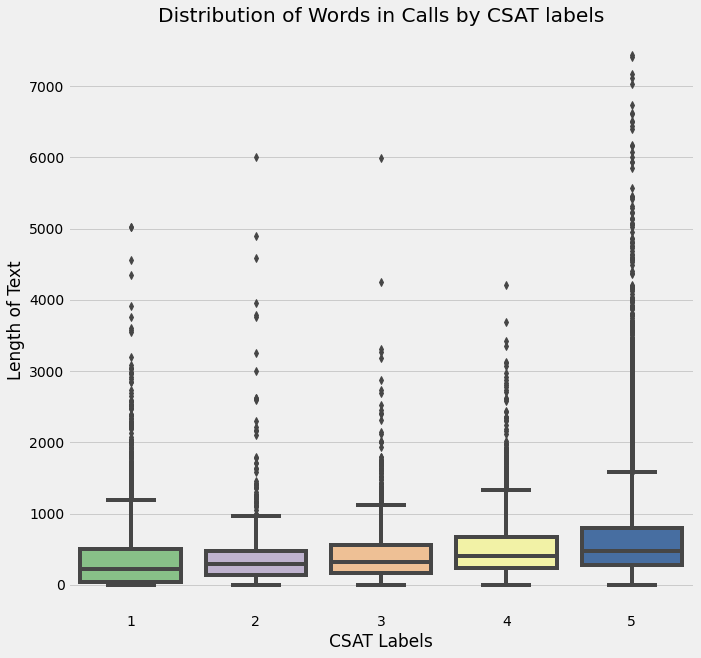

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

#there are 5 conversations where there are more than 8,000 words
sns.boxplot(x='response_value', y='text_length', data=df4[df4.text_length < 8000], palette='Accent')

plt.ylabel('Length of Text', fontsize=17)
plt.xlabel('CSAT Labels',fontsize=17)
plt.title('Distribution of Words in Calls by CSAT labels')

plt.show()

In [ ]:
df4.groupby('response_value')['text_length'].describe().reset_index()

,response_value,count,mean,std,min,25%,50%,75%,max
0,1,3217.0,385.100093,517.655401,0.0,41.00,215.0,503.00,5026.0
1,2,670.0,420.662687,577.171009,0.0,142.25,286.0,474.50,6000.0
2,3,1347.0,439.959169,459.982985,0.0,172.50,319.0,558.50,5988.0
3,4,2366.0,529.536348,449.161799,1.0,242.25,399.0,677.75,4211.0
4,5,21536.0,634.759983,602.780600,0.0,275.00,471.0,799.25,12635.0


In [ ]:
df4.groupby('response_value')['bert_tokenizer_length'].describe().reset_index()

,response_value,count,mean,std,min,25%,50%,75%,max
0,1,3217.0,504.732670,674.397058,0.0,54.0,287.0,661.00,6739.0
1,2,670.0,549.480597,738.144520,0.0,194.5,378.0,623.00,7313.0
2,3,1347.0,575.235338,588.718870,0.0,231.5,421.0,735.50,7593.0
3,4,2366.0,691.735841,577.338313,2.0,323.0,526.0,881.75,5218.0
4,5,21536.0,828.027210,779.318344,0.0,364.0,616.0,1044.00,15919.0


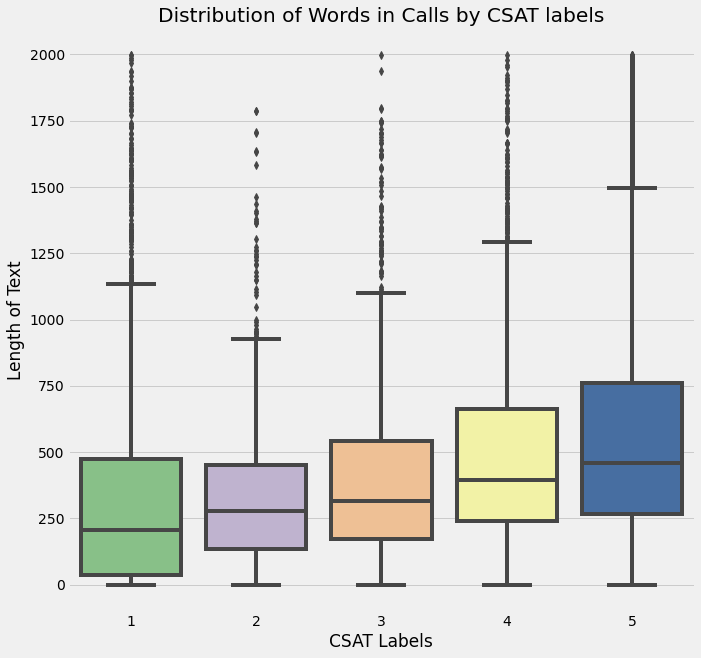

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')

#there are 5 conversations where there are more than 8,000 words
sns.boxplot(x='response_value', y='text_length', data=df4[df4.text_length < 2000], palette='Accent')

plt.ylabel('Length of Text', fontsize=17)
plt.xlabel('CSAT Labels',fontsize=17)
plt.title('Distribution of Words in Calls by CSAT labels')

plt.show()

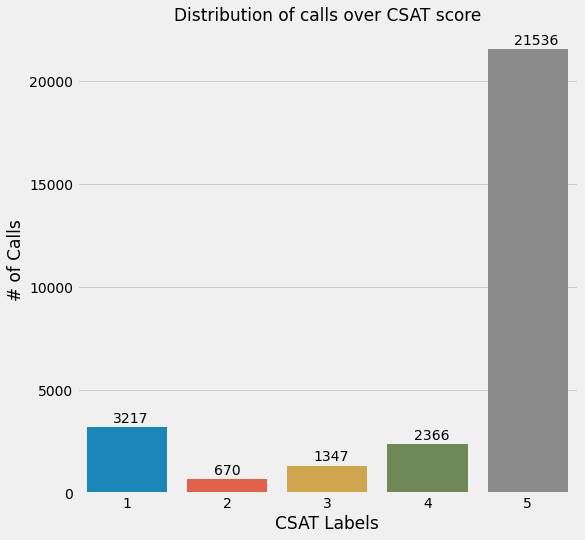

In [ ]:
plt.figure(figsize=(8,8))

xc=df4['response_value'].value_counts()
axc= sns.barplot(xc.index, xc.values)

xc_labels= xc.reset_index().sort_values('index',ascending=True)['response_value'].values.tolist()
annotate_labels(axc, xc_labels)

plt.title("Distribution of calls over CSAT score", fontsize=17)
plt.ylabel('# of Calls', fontsize=17)
plt.xlabel('CSAT Labels', fontsize=17)

plt.show()

#### Creating 2 classes for negative and positive reviews

* Reviews that are 1 and 2 stars will be encoded as a NEGATIVE CSAT, 0
* Reviews that are 4 and 5 stars will be encoded as a POSITIVE CSAT, 1

We left out 3 because for some reason has many calls that are related to cancellation of a service (based on manual inspection of calls in BQ). Why is this? Is it intentional or merely a coincidence? 

In [ ]:
# Encode calls with labels = 1, 2 to be negative CSAT (0) and calls with labels (4,5) to be positive CSAT (1). We left out 3 because 
filter_method = lambda x: 0 if x < 3 else 1 if (x >3) else None
dff = df4.copy()
dff['response_value'] = dff.response_value.apply(filter_method)

In [ ]:
#short_df = df4[df4.text_length.between(7,100)]
#df4[df4.text_length.between(71,100)].groupby(['response_value'])['call_id'].nunique()
#short_df.info()

In [ ]:
dff = dff[dff['response_value'].notna()]
dff = dff[dff.text_length > 5]

In [ ]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27217 entries, 0 to 29135
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   call_id                        27217 non-null  object 
 1   response_value                 27217 non-null  float64
 2   final_utterance                27217 non-null  object 
 3   duration                       27217 non-null  float64
 4   text_length                    27217 non-null  int64  
 5   bert_tokenizer_length          27217 non-null  int64  
 6   text                           27217 non-null  object 
 7   bert_tokenizer_length_no_punc  27217 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.9+ MB


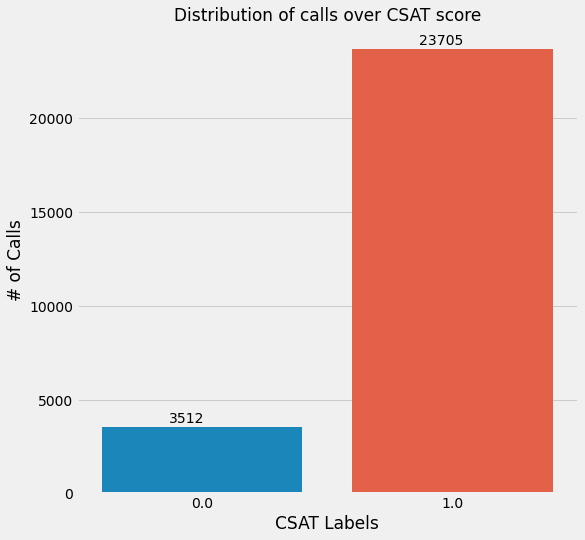

In [ ]:
plt.figure(figsize=(8,8))

xc=dff['response_value'].value_counts()
axc= sns.barplot(xc.index, xc.values)

xc_labels= xc.reset_index().sort_values('index',ascending=True)['response_value'].values.tolist()
annotate_labels(axc, xc_labels)

plt.title("Distribution of calls over CSAT score", fontsize=17)
plt.ylabel('# of Calls', fontsize=17)
plt.xlabel('CSAT Labels', fontsize=17)

plt.show()

In [ ]:
dff.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length
0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,515,698
1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,149
2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279
3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753
4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,697,921


In [ ]:
dff['text'] = dff['final_utterance'].str.replace(r'[^\w\s]+', '')
dff['bert_tokenizer_length_no_punc'] = dff.text.apply(lambda x: len(tokenizer.tokenize(x)))

In [ ]:
dff.head()

,call_id,response_value,final_utterance,duration,text_length,bert_tokenizer_length,text,bert_tokenizer_length_no_punc
0,4503600102440960,1.0,"this is daniel. how can i help? yes, no madam....",740.589,515,698,this is daniel how can i help yes no madam b...,543
1,4503602697142272,0.0,"for jacob speaking. how can i help you? hi, ho...",71.019,109,146,for jacob speaking how can i help you hi how y...,112
2,4503732200472576,1.0,"thank you for calling the street, this is aman...",237.557,217,279,thank you for calling the street this is amand...,229
3,4503877562466304,1.0,"help you today? yes, i'm just calling to confi...",265.920,588,753,help you today yes im just calling to confirm ...,616
4,4503914235691008,1.0,"solution federal i'm an offer innovations, chr...",351.710,695,912,solution federal im an offer innovations chris...,721


In [ ]:
# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/csat_final.csv', 'w') as f:
  dff.to_csv(f)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
dfb = dff[dff.bert_tokenizer_length_no_punc <= 512]
dfb.groupby(['response_value'])['call_id'].nunique() #16.9% = minority class

response_value
0.0     2527
1.0    12452
Name: call_id, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
%%time
vect = CountVectorizer()
vect.fit(dff.text)
print(len(vect.vocabulary_)) #The count vectorizer has extracted 50,667 words out of the corpus!

50667
CPU times: user 8.92 s, sys: 134 ms, total: 9.05 s
Wall time: 9.07 s


In [ ]:
%%time
neg_mat = vect.transform(dff[dff.response_value == 0].text)
pos_mat = vect.transform(dff[dff.response_value == 1].text)
neg_tf = np.sum(neg_mat,axis=0)
pos_tf = np.sum(pos_mat,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()

CPU times: user 13.4 s, sys: 67.9 ms, total: 13.5 s
Wall time: 13.5 s


In [ ]:
with open('/gdrive/My Drive/term_freq_df.csv', 'w') as f:
  term_freq_df.to_csv(f)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df2=pd.read_csv('gdrive/My Drive/term_freq_df.csv',header=None, skiprows=1,index_col=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df2.head()

,1,2
0,,
00,0,9
01,1,9
015,0,2
017,0,1
02,0,5


In [ ]:
df2.columns = ['negative', 'positive']
df2['total'] = df2['negative'] + df2['positive']

In [ ]:
df2.head()

,negative,positive,total
0,,,
00,0,9,9
01,1,9,10
015,0,2,2
017,0,1,1
02,0,5,5


In [ ]:
df2.sort_values(by='total', ascending=False).iloc[:20]

,negative,positive,total
0,,,
the,53926,554154,608080
you,54303,527830,582133
to,45299,404857,450156
and,37256,400020,437276
that,29839,313573,343412
okay,25471,278404,303875
so,22100,224128,246228
it,22672,215983,238655
is,20524,199012,219536
